Name: Li Liu

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

#### Deep classification model

In [163]:
import torch 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig 
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import lucem_illud_2020

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [164]:
%matplotlib inline

In [165]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [4]:
gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [181]:
df = pd.read_csv("sample.csv")
# Predict positive reviews
df['label'] = np.where(df['overall']>3, 1, 0)
# Only use the first 100 charatcers
df['sentence'] = [i[:100] for i in df['reviewText']]

In [182]:
df['label'].value_counts()

1    2026
0     541
Name: label, dtype: int64

In [206]:
2026/(541+2026)

0.7892481495909622

In [187]:
# resample to balance the classes
# Counts of two classes
count_class_1, count_class_0 = df['label'].value_counts()

# Divide the dataframe by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

# Sample count_class_0 amount of observations from df_class_1
df_class_1_under = df_class_1.sample(count_class_0, random_state=10)

# Combine the two dataframes
df_sample = pd.concat([df_class_1_under, df_class_0], axis=0)

In [188]:
df_sample['label'].value_counts()

1    541
0    541
Name: label, dtype: int64

In [189]:
df_sample.iloc[1]['sentence']

'I had one of these keyboards (this is my second) and only bought another as I accidentally spilled c'

In [84]:
df_sample.to_csv('sample_balanced.csv')

##### Predict with original data

In [190]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [191]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

I0526 20:46:26.965925 42180 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\lliu9/.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


Tokenize the first sentence:
['[CLS]', 'as', 'a', 'software', 'developer', ',', 'i', 'am', 'literally', 'attached', 'to', 'my', 'keyboard', '.', 'on', 'a', 'typical', 'day', ',', 'i', "'", 'll', 'spend', 'any', '##w', '##h', '[SEP]']


In [193]:
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [194]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

In [195]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [196]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 128, 32)           976704    
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [197]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
2310/2310 [==============================] - 7s 3ms/step - loss: 0.5227 - accuracy: 0.7944
Epoch 2/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5160 - accuracy: 0.7944: 2s - loss:
Epoch 3/10
2310/2310 [==============================] - 7s 3ms/step - loss: 0.5110 - accuracy: 0.7944
Epoch 4/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5106 - accuracy: 0.7944
Epoch 5/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5096 - accuracy: 0.7944
Epoch 6/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5096 - accuracy: 0.7944
Epoch 7/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5064 - accuracy: 0.7944
Epoch 8/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5109 - accuracy: 0.7944
Epoch 9/10
2310/2310 [==============================] - 6s 3ms/step - loss: 0.5088 - accuracy: 0.7944
Epoch 10/10
2310/2310 [==============================] - 6s 3ms/step -

##### Predict with re-sampled data

In [198]:
# Create sentence and label lists
sentences = df_sample.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_sample.label.values

In [199]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

I0526 20:48:21.682268 42180 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\lliu9/.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


Tokenize the first sentence:
['[CLS]', 'i', 'have', 'used', 'an', 'er', '##gon', '##omic', 'keyboard', 'since', 'about', '1996', '&', 'just', 'love', 'it', '.', 'i', 'can', "'", 't', 'type', 'on', 'a', 'standard', 'key', '##bo', '[SEP]']


In [200]:
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [201]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

In [202]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [203]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 128, 32)           976704    
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [204]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6976 - accuracy: 0.4810
Epoch 2/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6935 - accuracy: 0.4882
Epoch 3/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6941 - accuracy: 0.4954
Epoch 4/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.4954
Epoch 5/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.4985
Epoch 6/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6934 - accuracy: 0.4995
Epoch 7/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6934 - accuracy: 0.4707
Epoch 8/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6934 - accuracy: 0.4882
Epoch 9/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.5015
Epoch 10/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6935 - accuracy: 0.4779

In [205]:
units = 100
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm2.add(LSTM(unit))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(train_inputs, train_labels, epochs=10, batch_size=batch_size)

Epoch 1/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6942 - accuracy: 0.4923
Epoch 2/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6942 - accuracy: 0.4748
Epoch 3/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6941 - accuracy: 0.4902
Epoch 4/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6938 - accuracy: 0.4974
Epoch 5/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6931 - accuracy: 0.5026
Epoch 6/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.4985
Epoch 7/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.4954
Epoch 8/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6934 - accuracy: 0.5015
Epoch 9/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.5015
Epoch 10/10
973/973 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.5015

#### BERT

In [82]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [83]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [85]:
# model trained in Colab
model = BertForSequenceClassification.from_pretrained("model_save", num_labels=2)

I0524 20:24:13.473481 42180 configuration_utils.py:283] loading configuration file model_save\config.json
I0524 20:24:13.476473 42180 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

I0524 20:24:13.478493 42180 modeling_utils.py:648] loading weights file model_save\pytorch_model.bin


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df2 = pd.read_csv('sample_new.csv')
df2 = df2[df2['reviewText'].notnull()]

# Predict positive reviews
df2['label'] = np.where(df2['overall']>3, 1, 0)
# Only use the first 200 charatcers
df2['sentence'] = [i[:200] for i in df2['reviewText']]


# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df2.shape[0]))

# Create sentence and label lists
sentences = df2.sentence.values
labels = df2.label.values

In [138]:
count_class_1, count_class_0 = df2['label'].value_counts()

# Divide the dataframe by class
df2_class_0 = df2[df2['label'] == 0]
df2_class_1 = df2[df2['label'] == 1]

# Sample count_class_0 amount of observations from df_class_1
df2_class_1_under = df2_class_1.sample(count_class_0, random_state=10)

# Combine the two dataframes
df2_sample = pd.concat([df2_class_1_under, df2_class_0], axis=0)

In [91]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,624




## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [97]:
from transformers import BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

I0524 20:34:28.117846 42180 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\lliu9/.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [98]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [100]:
from transformers import pipeline

In [101]:
nlp_sentiment = pipeline('sentiment-analysis')

I0524 20:54:52.348126 42180 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at C:\Users\lliu9/.cache\torch\transformers\a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
I0524 20:54:52.350086 42180 configuration_utils.py:321] Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

I0524 20:54:52.570185 42180 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co

I0524 20:54:53.475383 42180 file_utils.py:440] storing https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json in cache at C:\Users\lliu9/.cache\torch\transformers\57ded08a298ef01c397973781194aa0abf6176e6f720f660a2b93e8199dc0bc7.455d944f3d1572ab55ed579849f751cf37f303e3388980a42d94f7cd57a4e331
I0524 20:54:53.482363 42180 file_utils.py:443] creating metadata file for C:\Users\lliu9/.cache\torch\transformers\57ded08a298ef01c397973781194aa0abf6176e6f720f660a2b93e8199dc0bc7.455d944f3d1572ab55ed579849f751cf37f303e3388980a42d94f7cd57a4e331
I0524 20:54:53.485355 42180 filelock.py:318] Lock 1433816336536 released on C:\Users\lliu9/.cache\torch\transformers\57ded08a298ef01c397973781194aa0abf6176e6f720f660a2b93e8199dc0bc7.455d944f3d1572ab55ed579849f751cf37f303e3388980a42d94f7cd57a4e331.lock
I0524 20:54:53.487350 42180 modelcard.py:161] loading model card file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-fine

I0524 20:54:53.774923 42180 modeling_utils.py:650] loading weights file https://cdn.huggingface.co/distilbert-base-uncased-finetuned-sst-2-english-pytorch_model.bin from cache at C:\Users\lliu9/.cache\torch\transformers\dd75d79590ca5f697e98574177cada739798baad3b771fd8f500e08f9f8b78cf.461f3160566473d3587f9f4776a5131b1ed527b0d5fccb4b5f06003f457154bc


In [107]:
nlp_sentiment("This BERT model is so good at classifiying sentiment, I love it.")[0]['label']

'POSITIVE'

In [108]:
nlp_sentiment("This BERT model is so good at classifiying sentiment, I love it.")[0]['score']

0.9997735023498535

In [132]:
df_sample['sentence_sentiment'] = [nlp_sentiment(i)[0]['label'] for i in df_sample['sentence']]
df_sample['sentence_score'] = [nlp_sentiment(i)[0]['score'] for i in df_sample['sentence']]
df_sample['sentence_sentiment'] = np.where(df_sample['sentence_sentiment']=='POSITIVE', 1, -1)
df_sample['sentence_score'] = df_sample['sentence_score']*df_sample['sentence_sentiment']

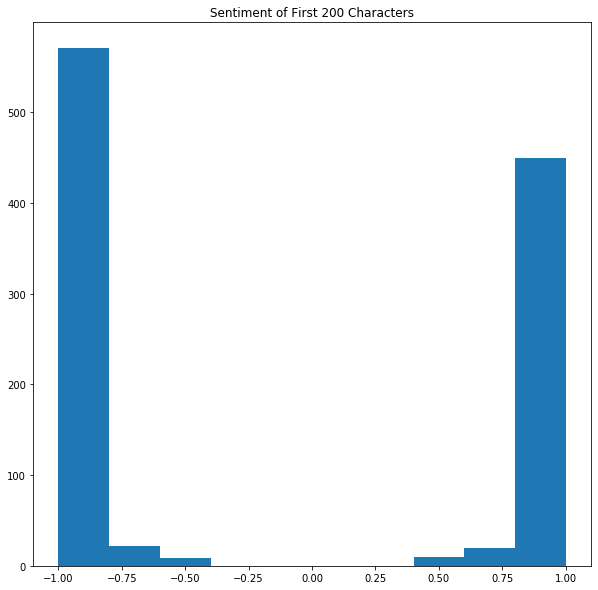

In [133]:
plt.figure(figsize=(10,10))
plt.hist(df_sample['sentence_score'])
plt.title("Sentiments of First 200 Characters")
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [134]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("output_gpt_review")
model_gpt = AutoModelWithLMHead.from_pretrained("output_gpt_review")

I0524 21:32:51.344599 42180 filelock.py:274] Lock 1434506739272 acquired on C:\Users\lliu9/.cache\torch\transformers\4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e.lock
I0524 21:32:51.345613 42180 file_utils.py:436] https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json not found in cache or force_download set to True, downloading to C:\Users\lliu9\.cache\torch\transformers\tmpa5tpj809


I0524 21:32:51.608154 42180 file_utils.py:440] storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json in cache at C:\Users\lliu9/.cache\torch\transformers\4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
I0524 21:32:51.612142 42180 file_utils.py:443] creating metadata file for C:\Users\lliu9/.cache\torch\transformers\4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
I0524 21:32:51.615134 42180 filelock.py:318] Lock 1434506739272 released on C:\Users\lliu9/.cache\torch\transformers\4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e.lock
I0524 21:32:51.617128 42180 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at C:\Users\lliu9/.cache\torch\tr

I0524 21:32:51.896983 42180 filelock.py:274] Lock 1434506388928 acquired on C:\Users\lliu9/.cache\torch\transformers\f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71.lock
I0524 21:32:51.899973 42180 file_utils.py:436] https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json not found in cache or force_download set to True, downloading to C:\Users\lliu9\.cache\torch\transformers\tmpx5ifuy9_


I0524 21:32:52.382320 42180 file_utils.py:440] storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json in cache at C:\Users\lliu9/.cache\torch\transformers\f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
I0524 21:32:52.385312 42180 file_utils.py:443] creating metadata file for C:\Users\lliu9/.cache\torch\transformers\f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
I0524 21:32:52.388303 42180 filelock.py:318] Lock 1434506388928 released on C:\Users\lliu9/.cache\torch\transformers\f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71.lock


I0524 21:32:52.611953 42180 filelock.py:274] Lock 1434506456424 acquired on C:\Users\lliu9/.cache\torch\transformers\d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
I0524 21:32:52.614935 42180 file_utils.py:436] https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt not found in cache or force_download set to True, downloading to C:\Users\lliu9\.cache\torch\transformers\tmp_1c63ut2


I0524 21:32:53.119925 42180 file_utils.py:440] storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt in cache at C:\Users\lliu9/.cache\torch\transformers\d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
I0524 21:32:53.122868 42180 file_utils.py:443] creating metadata file for C:\Users\lliu9/.cache\torch\transformers\d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
I0524 21:32:53.125861 42180 filelock.py:318] Lock 1434506456424 released on C:\Users\lliu9/.cache\torch\transformers\d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
I0524 21:32:53.126857 42180 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at C:\Users\lliu9/.cache\torch\transformers\f2808

I0524 21:32:53.449318 42180 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at C:\Users\lliu9/.cache\torch\transformers\4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
I0524 21:32:53.450316 42180 configuration_utils.py:321] Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {


I0524 21:33:36.310857 42180 file_utils.py:440] storing https://cdn.huggingface.co/gpt2-pytorch_model.bin in cache at C:\Users\lliu9/.cache\torch\transformers\d71fd633e58263bd5e91dd3bde9f658bafd81e11ece622be6a3c2e4d42d8fd89.778cf36f5c4e5d94c8cd9cefcf2a580c8643570eb327f0d4a1f007fab2acbdf1
I0524 21:33:36.315841 42180 file_utils.py:443] creating metadata file for C:\Users\lliu9/.cache\torch\transformers\d71fd633e58263bd5e91dd3bde9f658bafd81e11ece622be6a3c2e4d42d8fd89.778cf36f5c4e5d94c8cd9cefcf2a580c8643570eb327f0d4a1f007fab2acbdf1
I0524 21:33:36.319829 42180 filelock.py:318] Lock 1434506701792 released on C:\Users\lliu9/.cache\torch\transformers\d71fd633e58263bd5e91dd3bde9f658bafd81e11ece622be6a3c2e4d42d8fd89.778cf36f5c4e5d94c8cd9cefcf2a580c8643570eb327f0d4a1f007fab2acbdf1.lock
I0524 21:33:36.320829 42180 modeling_utils.py:650] loading weights file https://cdn.huggingface.co/gpt2-pytorch_model.bin from cache at C:\Users\lliu9/.cache\torch\transformers\d71fd633e58263bd5e91dd3bde9f658bafd81e

I0524 21:33:40.358036 42180 modeling_utils.py:741] Weights of GPT2LMHeadModel not initialized from pretrained model: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']


In [135]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df_sample['sentence'], test_size=0.2)

In [140]:
train_text2, test_text2 = train_test_split(df2_sample['sentence'], test_size=0.2)

In [136]:
train_text.to_frame().to_csv(r'train_text', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text', header=None, index=None, sep=' ', mode='a')

In [141]:
train_text2.to_frame().to_csv(r'train_text2', header=None, index=None, sep=' ', mode='a')
test_text2.to_frame().to_csv(r'test_text2', header=None, index=None, sep=' ', mode='a')

In [ ]:
# model trained in Colab
tokenizer_review = AutoTokenizer.from_pretrained("output_gpt_review")
model_review = AutoModelWithLMHead.from_pretrained("output_gpt_review")

In [ ]:
sequence = "I like it, but"

input = tokenizer_review.encode(sequence, return_tensors="pt")
generated = model_review.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_review.decode(generated.tolist()[0])
print(resulting_string)

=== GENERATED SEQUENCE 1 ===

i like it but this router doesn't do it for me. I've been using it for years now, but it

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

In [153]:
from scipy.spatial.distance import cosine

In [ ]:
import seaborn as sns
from scipy.spatial.distance import cosine
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [143]:
roberta_m2_model_embedding = RobertaModel.from_pretrained('output_gpt_review2')
roberta_m2_tokenizer = RobertaTokenizer.from_pretrained('output_gpt_review2')

I0524 22:56:04.572855 42180 configuration_utils.py:283] loading configuration file output_gpt_review2\config.json
I0524 22:56:04.574849 42180 configuration_utils.py:321] Model config RobertaConfig {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_p

I0524 22:56:08.379711 42180 modeling_utils.py:747] Weights from pretrained model not used in RobertaModel: ['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight',

In [149]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [150]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [159]:
text = "This is a very nice keyboard"

<IPython.core.display.Javascript object>

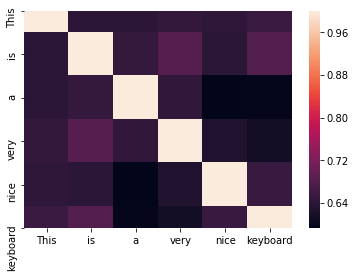

In [161]:
visualise_diffs(text, roberta_m1_model_embedding, roberta_m1_tokenizer)

<IPython.core.display.Javascript object>

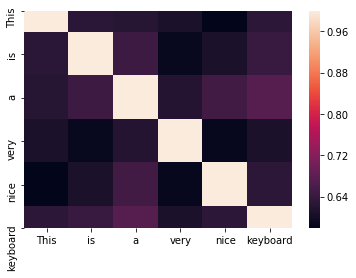

In [162]:
visualise_diffs(text, roberta_m2_model_embedding, roberta_m2_tokenizer)

I didn't see much difference in the two heatmap visualizations. This suggests the two sets of product reviews are quite similar.